# Проект: Обучение с учителем: качество модели

# **Описание проекта**

**Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.**

**«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.**

**Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**

## Загрузка данных

**Импортируем необходимые библиотеки, фунцкции и классы:**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install phik -q
import phik

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
!pip install shap -q
import shap

**Загрузим по очереди каждый датасет и посмотрим на данные в нем:**

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.rename(columns=str.lower, inplace=True)
market_file.info()
display(market_file.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.rename(columns=str.lower, inplace=True)
market_money.info()
display(market_money.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.rename(columns=str.lower, inplace=True)
market_time.info()
display(market_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money.rename(columns=str.lower, inplace=True)
money.info()
display(money.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Все таблицы импортировались коректно, можно переходить к предобработке данных.**

## Предобработка данных

**Переименуем некоторые столбцы в первой таблице:**

In [10]:
market_file = market_file.rename(columns={'покупательская активность':'покупательская_активность',
                                          'тип сервиса':'тип_сервиса',
                                          'разрешить сообщать':'разрешить_сообщать'})
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

**Проверим на пропуски и нули первую таблицу:**

In [11]:
display(market_file.isna().sum(), market_file.duplicated().sum())

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

0

**Теперь таким же образом проверим вторую таблицу:**

In [12]:
display(market_money.isna().sum(), market_money.duplicated().sum())

id         0
период     0
выручка    0
dtype: int64

0

**На очереди третья таблица:**

In [13]:
display(market_time.isna().sum(), market_time.duplicated().sum())

id        0
период    0
минут     0
dtype: int64

0

**И последняя таблица:**

In [14]:
display(money.isna().sum(), money.duplicated().sum())

id         0
прибыль    0
dtype: int64

0

**В ходе предобработки данных мы изменили названия некоторых столбцов в первой таблице. Пропусков и нулей обнаружено не было.**

## Исследовательский анализ данных

**Проведем исследовательский анализ данных каждой таблицы (столбцы id в каждой таблице будем игнорировать, т.к. они обозначают номер пользователя.**

**Напишем функцию для построения графики гистограммы и ящика с усами для количественных признаков:**

In [15]:
def charts(df, column):

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=20)
    plt.title(f'Гистограмма для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами для {column}')
    plt.tight_layout()
    plt.show()

**Теперь применим ее для каждого количественного столбца по очереди:**

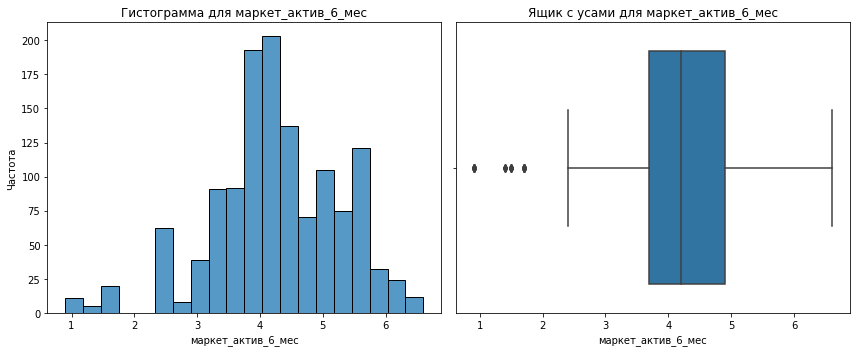

In [16]:
charts(market_file, 'маркет_актив_6_мес')

**На графиках мы видим выбросы в левой части, однако учитывая что этот признак показывает среднее число рассылок, звонков, показов рекламы и прочего приходилось на клиента, такие значения имеют место быть, и удалять их не стоит.**

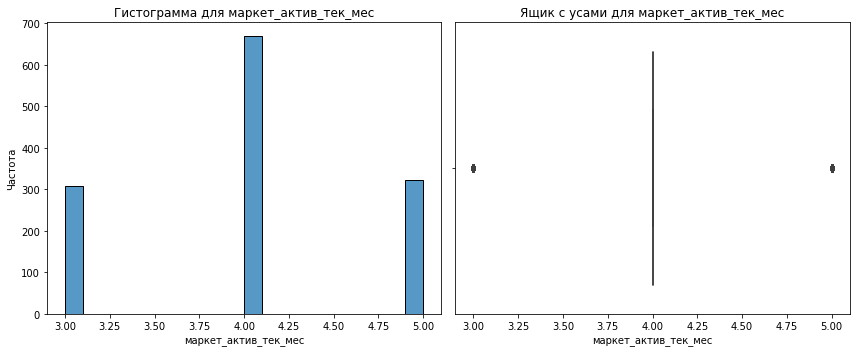

In [17]:
charts(market_file, 'маркет_актив_тек_мес')

**Тут мы видим три целых значения, от 3 до 5, что вполне реально, так как этот признак показывает оличество маркетинговых коммуникаций в текущем месяце и имеет только целые значения.**

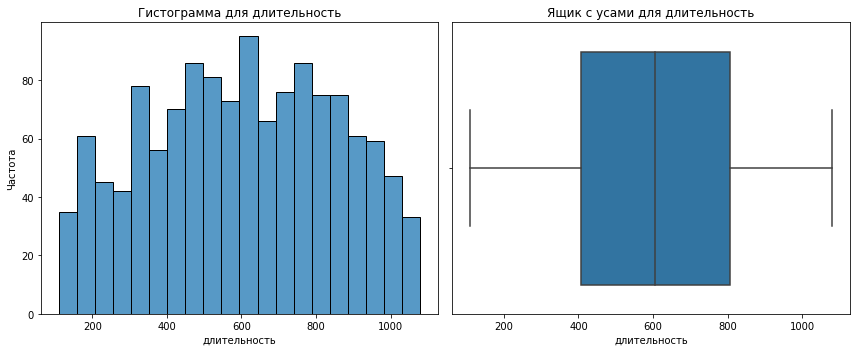

In [18]:
charts(market_file, 'длительность')

**Тут все отлично, нормальное распределение без аномалий и выбросов.**

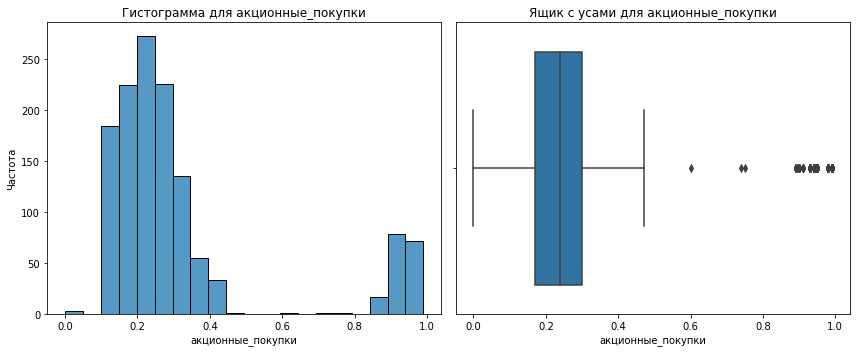

In [19]:
charts(market_file, 'акционные_покупки')

**Тут мы видим много выбросов в левой части, но это абсолютно реальные значения, так как этот признак показывает среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев, и распределяется от 0 до 1.**

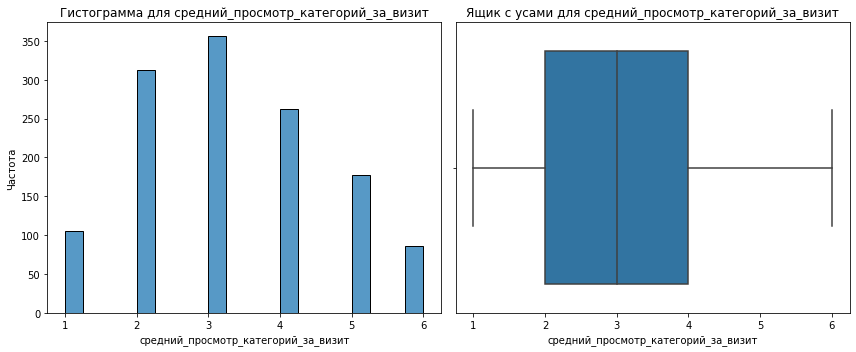

In [20]:
charts(market_file, 'средний_просмотр_категорий_за_визит')

**Тут все отлчино, нет выбросов, данных распределены анологично столбцу "маркет_актив_тек_мес".**

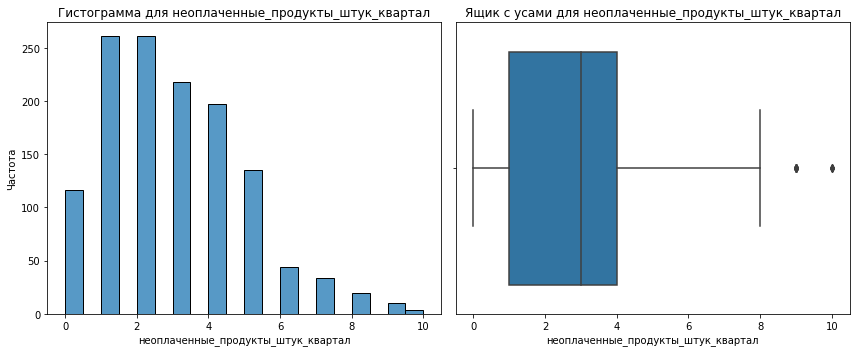

In [21]:
charts(market_file, 'неоплаченные_продукты_штук_квартал')

**С этим признаком схожая ситуация, однако видны небольшие выбросы в правой части, которые являются реальными значениями.**

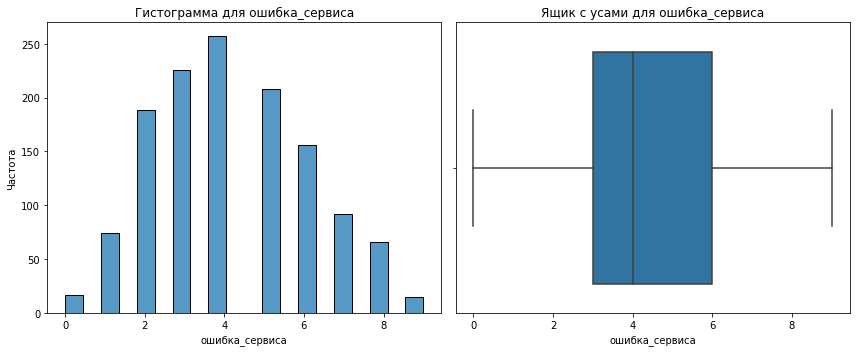

In [22]:
charts(market_file, 'ошибка_сервиса')

**С этим признаком все отлично, можно переходить дальше.**

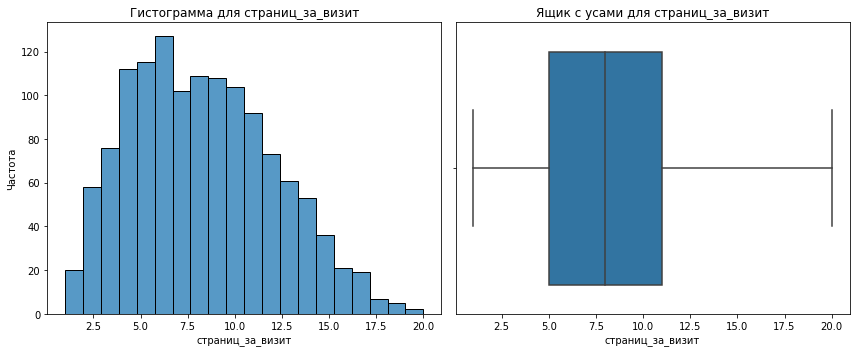

In [23]:
charts(market_file, 'страниц_за_визит')

**Тут также все хорошо.**

**Напишем функцию, которая будет строить график для качественных переменных:**

In [24]:
def charts_col(df, column):

    counts = df[column].value_counts()
    counts.plot(kind='pie', figsize=(12,5), autopct='%1.1f%%')
    plt.title(f'График соотношения для {column}')
    plt.ylabel('')
    plt.show()

**Применим ее по очереди к каждому качественному признаку:**

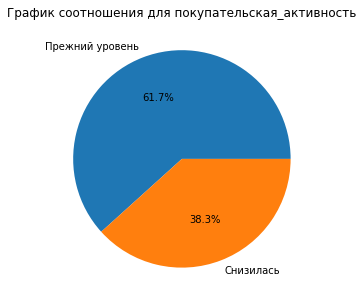

In [25]:
charts_col(market_file, 'покупательская_активность')

**Видим соотношение в большую сторону к клиентам, с прежним уровнем покупательской активности.**

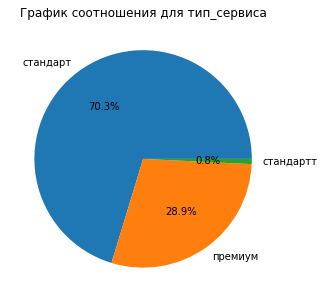

In [26]:
charts_col(market_file, 'тип_сервиса')

**Видим тут неявный дубликат, устраним его:**

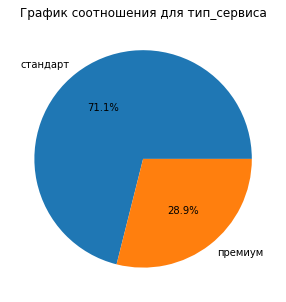

In [27]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
charts_col(market_file, 'тип_сервиса')

**Теперь все хорошо, видим что более 70% пользователей имеют стандартный тип сервиса.**

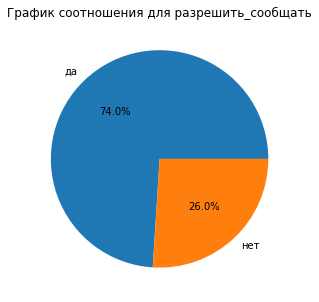

In [28]:
charts_col(market_file, 'разрешить_сообщать')

**Все нормально, большая часть пользователей разрешают сообщать присылать покупателю дополнительные предложения о товаре.**

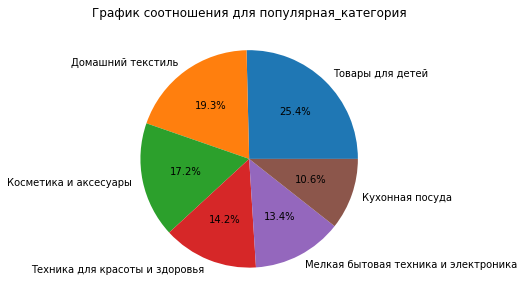

In [29]:
charts_col(market_file, 'популярная_категория')

**Нет никаких дубликатов, видим примерно равное распределение категорий товаров.**

**Теперь, с помощью написаных функций, также исследуем оставшиеся таблицы:**

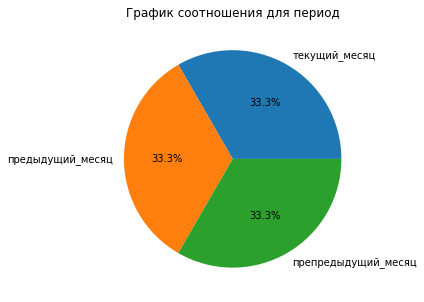

In [30]:
charts_col(market_money, 'период')

**Все хорошо, видим соотношения перодов.**

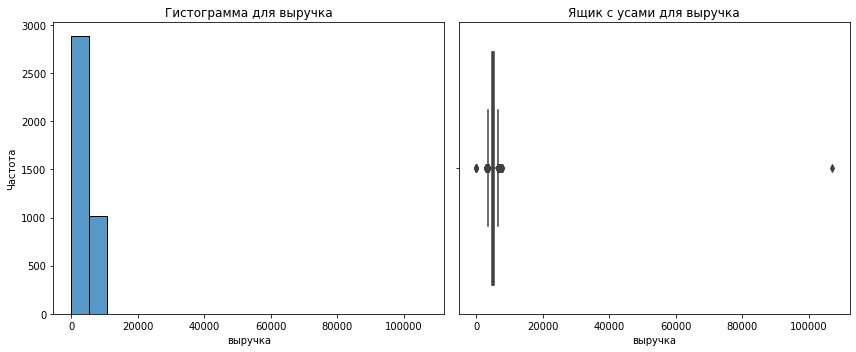

In [31]:
charts(market_money, 'выручка')

**Видим явную аномалию в правой части графика, заменим ее значение медианным, чтобы в дальнейшем при объединении таблиц у нас не возникало сложностей:**

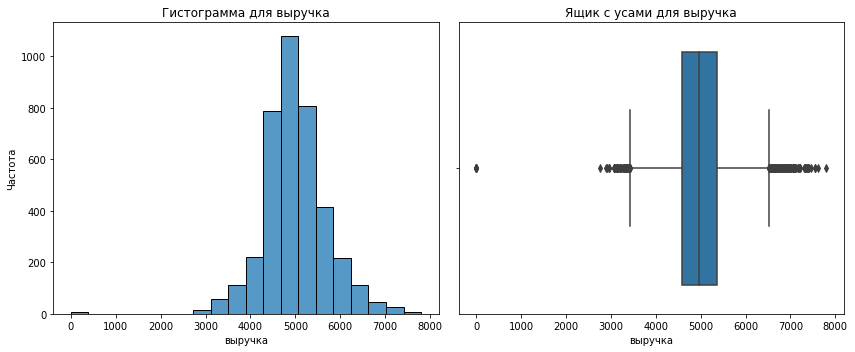

In [32]:
filtered_data = market_money[market_money['выручка'] < 100000]
median = filtered_data['выручка'].median()
market_money.loc[market_money['выручка'] > 100000, 'выручка'] = median
charts(market_money, 'выручка')

**Теперь мы видим аномалии возле нуля, взгянем на них:**

In [33]:
market_money[market_money['выручка']<100]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


**Это оказались 3 пользователя с нулевой выручкой за предыдущий и препредыдущий месяцы (всего 6 записей). Т.к. по заднанию надо отбрать клиентов с покупательской активностью не менее трёх месяцев, удалим их:**

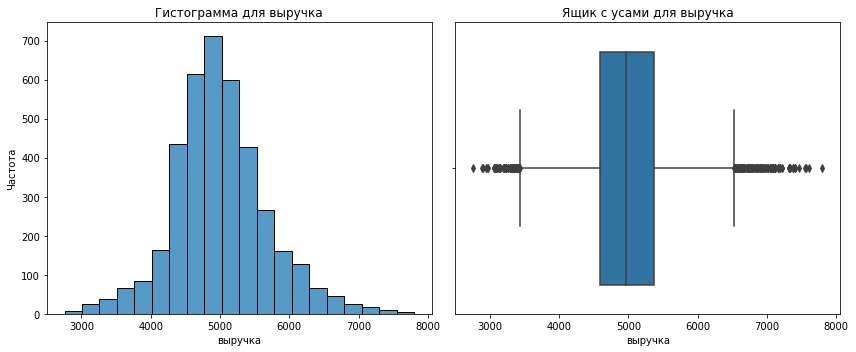

In [34]:
market_money = market_money[market_money['id']!=215348]
market_money = market_money[market_money['id']!=215359]
market_money = market_money[market_money['id']!=215357]
charts(market_money, 'выручка')

**Чтобы далее не возникло путаницы, удалим этих пользователей из других таблиц:**

In [35]:
def delete (df):
    df = df[df['id']!=215348]
    df = df[df['id']!=215359]
    df = df[df['id']!=215357]
    return df
market_file = delete(market_file)
market_time = delete(market_time)
money = delete(money)

**Перейдем к следующей таблице:**

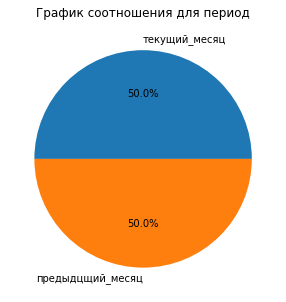

In [36]:
charts_col(market_time, 'период')

**Видим равное отношение предыдущего и текущего месяцев, но опечатку в слове предыдущий. Испровим ее:**

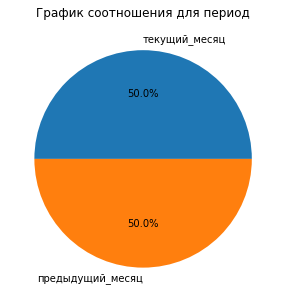

In [37]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
charts_col(market_time, 'период')

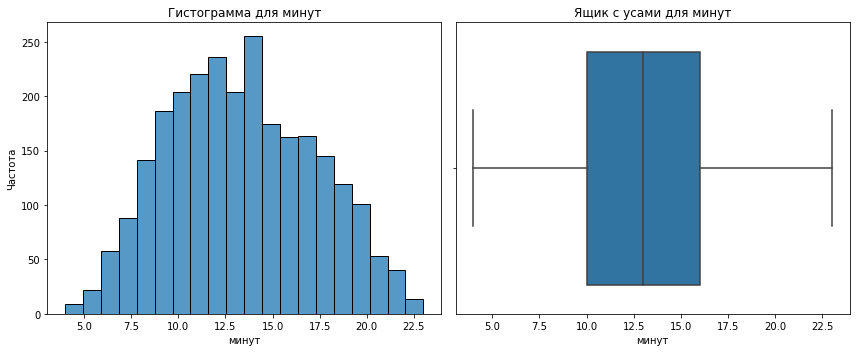

In [38]:
charts(market_time, 'минут')

**Видим отличное распределение без выбросов и аномалий.**

**Переходим к последней таблице:**

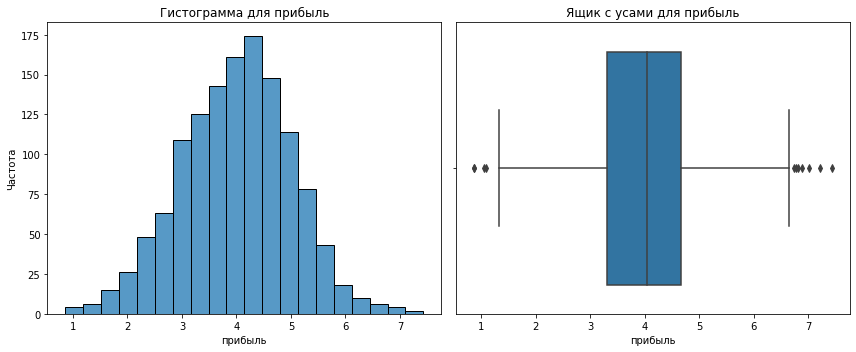

In [39]:
charts(money, 'прибыль')

**Видим нормальное распределение с небольшими выбросами по краям графика, однако это вполне реальные значения прибыли.**

**В ходе исследовательского анализа данных, мы нашли неявные дубликаты, аномалии и истранили их.**

**Сравним пользователей со снижением активности и с активность на прежнем уровне.**

**Разделим пользоватей по таргету:**

In [40]:
market_file_low = market_file[market_file['покупательская_активность'] == 'Снизилась']

In [41]:
market_file_high = market_file[market_file['покупательская_активность'] == 'Прежний уровень']

**Выведем для каждой группы таблицу с некоторыми значениями:**

In [42]:
market_file_low.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,215612.123232,3.743030,4.006061,622.862626,0.453697,2.622222,3.729293,3.939394,5.577778
std,165.138584,1.055728,0.707081,237.577077,0.304908,1.222558,2.291387,1.880101,3.460815
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,1.000000,1.000000
25%,215474.500000,3.100000,4.000000,449.000000,0.240000,2.000000,2.000000,2.000000,3.000000
50%,215598.000000,3.900000,4.000000,637.000000,0.310000,2.000000,4.000000,4.000000,5.000000
75%,215721.500000,4.400000,5.000000,812.000000,0.890000,3.000000,5.000000,5.000000,7.000000
max,215941.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,18.000000


In [43]:
market_file_high.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,216237.761845,4.570075,4.011222,590.730673,0.238367,3.665835,2.293017,4.335411,9.796758
std,246.221370,0.848618,0.689586,255.330179,0.160599,1.277112,1.508255,1.979538,3.376846
min,215748.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000
25%,216046.250000,4.000000,4.000000,382.500000,0.150000,3.000000,1.000000,3.000000,7.000000
50%,216246.500000,4.400000,4.000000,590.000000,0.210000,4.000000,2.000000,4.000000,10.000000
75%,216446.750000,5.275000,4.000000,798.750000,0.260000,5.000000,3.000000,6.000000,12.000000
max,216647.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,8.000000,9.000000,20.000000


**Нас интересует вторая строка в каждой таблице со значением среднего. Посмотрим на разницу средних значений каждого количественного признака в этих группах:**

In [44]:
a = market_file_low.describe().iloc[1:2]
b = market_file_high.describe().iloc[1:2]
c = b-a
c

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
mean,625.638613,0.827045,0.005161,-32.131953,-0.21533,1.043613,-1.436275,0.396018,4.21898


**Видим, что за последние 6 месяцев пользователи с прежним уровнем активности получали значительно больше рассылок, просматриват в среднем более чем на одну категорию больше за визит, и посещают почти в два раза больше страниц за визит. Также по разнице в длительности видно, что пользователи со снижающемся уровнем активности это более старые пользователи. У пользователей с прежним уровнем активности среднее количество неоплаченных товаров в корзине меньше почти на 1.5 позиции, а доля акционных покупок в два раза меньше. Средняя активность за текущий месяц примерно на одном уровне.** 

**Таким образом, три самых различающихся признака пользоватей двух групп, это маркет_актив_6_мес, страниц_за_визит, акционные_покупки. При прогнозировании и при анализе пользователей, следуют уделять больше внимания этим признакам.**

## Объединение таблиц

**Объединим таблицы market_file, market_money, market_time. Объединять будем по признаку id c помощью двух сводных таблиц:**

In [45]:
pivot_1 = pd.pivot_table(market_money, index='id', columns='период', values='выручка')
pivot_1 = pivot_1.rename(columns={'предыдущий_месяц':'предыдущий_месяц_выручка',
                                          'препредыдущий_месяц':'препредыдущий_месяц_выручка',
                                          'текущий_месяц':'текущий_месяц_выручка'})

In [46]:
market_final = pd.merge(market_file, pivot_1, on='id', how='outer')

In [47]:
pivot_2 = pd.pivot_table(market_time, index='id', columns='период', values='минут')
pivot_2 = pivot_2.rename(columns={'предыдущий_месяц':'предыдущий_месяц_минут',
                                         'текущий_месяц':'текущий_месяц_минут'})

In [48]:
market_final = pd.merge(market_final, pivot_2, on='id', how='outer')

In [49]:
market_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

**В общей таблице добавилось три новых признака.**

**Теперь, объединив таблицы можем приступать к корреляционному анализу.**

## Корреляционный анализ

**Посмотри на корреляцию всех признаков при помощи phik мтарицы. Но для начала, откинем признак id, т.к. он никак не повлияет на зависимости в модели.**

In [50]:
market_final_copy = market_final
market_final = market_final.drop(['id'], axis=1)

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_минут', 'текущий_месяц_минут']


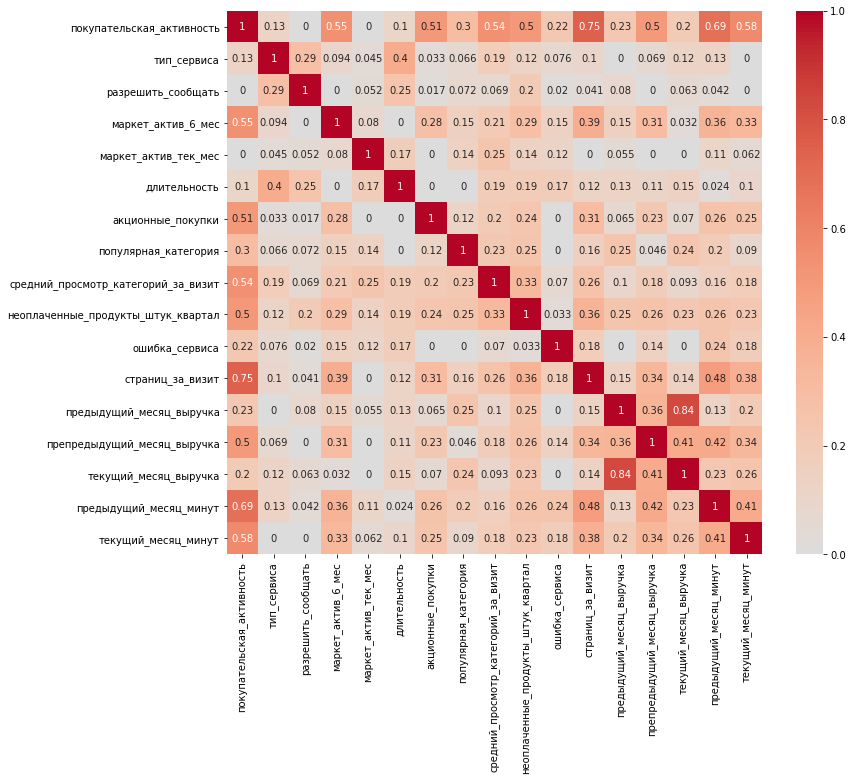

In [51]:
phik_matrix = market_final.phik_matrix()
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', center=0)
plt.show();

**Глядя на таблицу коллинеарности можно сделать вывод, что мультиколлинеарность отсутствует.**

## Использование пайплайнов

**Применим все изученные модели. Для этого используем пайплайны.**

**Для начала зададим константы:**

In [52]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

**Теперь разделим выборку на тренировочную и тестовую:**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    market_final.drop(['покупательская_активность'], axis=1),
    market_final['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_final['покупательская_активность'])

**Обозначим какие признаки требуют кодирования, а какие масштабирования. Т.к. признак 'тип_сервиса' является порядковым, его будем кодировать другим способом.**

In [54]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']

ord_columns = ['тип_сервиса']

num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
              'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал',
              'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_выручка',
              'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',
              'предыдущий_месяц_минут', 'текущий_месяц_минут'] 

**Добавляем OHE-кодирование в пайплайн:**

**Мы будем использовать SimpleImputer для заполнения пропусков на разных этапах работы пайплана**

In [55]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

**Добавляем Ordinal-кодирование в пайплайн:**

In [56]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

**Объединяем шаги подготовки:**

In [57]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Создаём итоговый пайплайн для обучения модели:**

In [58]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

**Зададим словарь гиперпараметров для моделей и вариантов масштабирования:**

In [59]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'models__alpha': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

**Так как у нас классы в целевом признаке распределены примерно 62 на 38 процентов, будем использовать метрику roc-auc. Найдем лучшую модель при помощи рандомизированного поиска:**

In [67]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', randomized_search.best_score_)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/conda/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 690, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 621, in _fit_transform
    return Parallel(n_jobs=self.n_jobs)(
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 414, in fit_transform
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/conda/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py", line 1294, in fit
    self._fit(X, handle_unknown=self.handle_unknown, force_all_finite="allow-nan")
  File "/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py", line 106, in _fit
    cats = np.array(self.categories[i], dtype=Xi.dtype)
ValueError: could not convert string to float: 'стандарт'


**Лучшей окакалась модель логистической регрессии, с хорошим результатом.**

**Убедимся что модель, которую мы видим, лучшая, выполнив поиск по сетке(с перебором всех комбинаций):**

In [61]:
grid = GridSearchCV(
    pipe_final, 
   param_grid=param_grid, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', grid.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                        

**Видим, что перебор по всей сетке дал свои плоды, лучшим оказался метод опорных векторов, с результатом чуть выше чем у логистической регрессии.**

**Мы нашли лучшую модель, ей оказалась SVC с результатом метрики roc-auc в 0.914. Протестируем ее на тестовой выборке:**

In [62]:
model = grid.best_estimator_
probabilities = model.predict_proba(X_test) 
probabilities_one = probabilities[:, 1] 

print('Площадь ROC-кривой на тестовой выборке:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой на тестовой выборке: 0.9177900818488204


**На тестовой выборке метрика оказалась немного выше.**

## Анализ важности признаков

**Посторим графики SHAP для интерпритации признаков. Для начала обучим модель:**

In [63]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names(ohe_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train[ord_columns] = ordinal_encoder.fit_transform(X_train[ord_columns])
X_test[ord_columns] = ordinal_encoder.fit_transform(X_test[ord_columns])

X_train_data = np.concatenate([X_train_ohe, X_train_scaled, X_train[ord_columns].values], axis=1)
X_test_data = np.concatenate([X_test_ohe, X_test_scaled, X_test[ord_columns].values], axis=1)


all_col_names = np.concatenate([encoder_col_names, num_columns, ord_columns])

X_train_data_df = pd.DataFrame(X_train_data, columns=all_col_names)
X_test_data_df = pd.DataFrame(X_test_data, columns=all_col_names)

**Для ускорения вычисления shap значений, сократим выробку до 100 значений**

In [64]:
model = SVC(probability=True, random_state=42)
model.fit(X_train_data_df, y_train)

#n_samples = 10
#X_sample = X_test_data_df.sample(n=n_samples, random_state=1)

#explainer = shap.SamplingExplainer(lambda x: model.predict_proba(x)[:, 1], X_sample)

#shap_values = explainer.shap_values(X_sample)

#plt.figure(figsize=(100, 100))
#shap.summary_plot(shap_values, X_sample, feature_names=all_col_names)

SVC(probability=True, random_state=42)

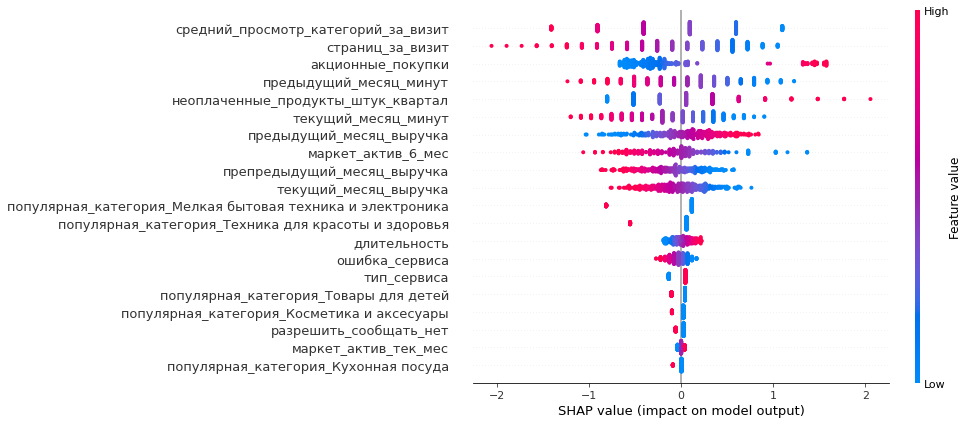

In [65]:
model = LogisticRegression()
model.fit(X_train_data_df, y_train)
X_sample = X_test_data_df.sample(frac=0.1, random_state=1)


explainer = shap.Explainer(model, X_sample)
shap_values = explainer.shap_values(X_test_data_df)
shap.summary_plot(shap_values, X_test_data_df, plot_size=[14,6])

**Глядя на график, можно сделать выводы, что наименее значимыми являются признаки популярных категорий товара, и разрешиения на рассылку. Сильнее всего на целевой признак влияют признак страниц за визит, минут за предыдущий месяц и акционные покупки. Это можно использовать в бизнесе, чтобы в дальнейшем ввести больший акцент на времени, проводимом пользователем на сайте.**

## Сегментация покупателей

**Выделим сегмент покупателей с предсказанным уменьшающимся уровнем активности и высокой прибылью.**

**Добавим в таблицу признаки которые были даны в диаграме Исикавы заказчиком. Признак время на сайте за прошлый год мы добавить не сможем, т.к. у нас нет никакой информации о нем. А вот признаки с разницой в выручке мы легко найдем с помощью данных из нашей таблиы:**

In [ ]:
market_final_copy['разница_тек_пред'] = market_final_copy['текущий_месяц_выручка'] - market_final_copy['предыдущий_месяц_выручка']
market_final_copy['разница_пред_препред'] = market_final_copy['предыдущий_месяц_выручка'] - market_final_copy['препредыдущий_месяц_выручка']
market_final_copy.head()

**Теперь , удалим целевой признак из нашей таблицы, чтобы сделать предсказания:**

In [ ]:
new_df = market_final_copy.drop(['покупательская_активность', 'id'], axis=1)

**Предоработуем данные:**

In [ ]:
new_ohe_transformed = encoder.transform(new_df[ohe_columns])

new_ohe_df = pd.DataFrame(new_ohe_transformed, columns=encoder.get_feature_names(ohe_columns))

new_scaled = scaler.transform(new_df[num_columns])

new_df_ord = new_df
new_df_ord[ord_columns] = ordinal_encoder.transform(new_df_ord[ord_columns])

new_data = np.concatenate([new_ohe_df, new_scaled, new_df_ord[ord_columns].values], axis=1)

new_all_col_names = np.concatenate([encoder.get_feature_names(ohe_columns), num_columns, ord_columns])

new_data_df = pd.DataFrame(new_data, columns=new_all_col_names)

**Получим вероятности предсказаний лучшей модели:**

In [ ]:
pred_score = model.predict_proba(new_data_df)

**Добавим вероятности в изначальную таблицу:**

In [ ]:
market_final_copy['вероятность'] = pred_score[:, 1]

**Теперь у нас в последнем столбце появилась вероятность того, что активность пользователя снизится**

**Присоединим таблицу с прибыльностью каждого пользователя:**

In [ ]:
segment = pd.merge(market_final_copy, money, on='id', how='left')

**Используя результаты моделирования, постороим график по вероятности снижения активности и по выручке:**

In [ ]:
plt.figure(figsize=(12, 5)) 
plt.scatter(segment['вероятность'], segment['прибыль'], color='blue')
plt.title('График вероятности снижения активности и прибыли') 
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль') 
plt.grid(True) 
plt.show()

**Напомним, что базово модель присвает какой либо класс, если вероятность равна более 0.5, однако это значение можно настроивать для конкретной задачи. На графике видно, что примерно после 0.8 начинается большое скопление пользователей, приносящий как маленькую, так и большу прибыль. Имеет смысл, взять пользователей, с вероятность снижения активности более 0.8 и прибылью более 2(т.к. до 2 не так много пользователей, и в первую очередь нужно пытаться удержать 'прибыльных' клиентов.**

**Для начала отсортируем этих пользователей:**

In [ ]:
segment = segment.query('вероятность>0.8 & прибыль>2')

In [ ]:
segment.shape

**Всего у нас 364 таких пользователя, примерно пятая часть изначального датафрейма.**

**Теперь, с помощью гарафиков, исследуем этих пользователей:**

**Посмотрим, сколько категорий в среднем они просматривают:**

In [ ]:
charts(segment, 'средний_просмотр_категорий_за_визит')

**Чаще всего, они посещают 2-3 категории. Это довольно мало, т.к. покупатель даже не успевает ознакомиться со всеми категориями товаров. Взглянем на популярные категории:**

In [ ]:
charts_col(segment, 'популярная_категория')

**У них четыре самые популярные категории: товары для детей, косметика и аксесуары, домашний текстиль, кухонная посуда. Исходя из категорий, можно выдвинуть гипотезу, что это домахозяйки с детьми. Посмотрим на процент купленных товаров на акции:**

In [ ]:
charts(segment, 'акционные_покупки')

**Видим, что в среднем пользователи покупают треть товаров по акции, однако есть и те, кто почти всегда берет по акции. Посмотрим, какой тип сервиса они используют:**

In [ ]:
charts_col(segment, 'тип_сервиса')

**Большинство использует стандартный, но чуть более трети пользуется премиумом.**

**Посмотрим на разницу в прибыли за последние месяца:**

In [ ]:
charts(segment, 'разница_тек_пред')

In [ ]:
charts(segment, 'разница_пред_препред')

**Каждый месяц, выручка в среднем вырастает примерно на 500. Посмотрим на среднее значение рассылок за последние пол года и последний месяц:**

In [ ]:
charts(segment, 'маркет_актив_6_мес')

In [ ]:
charts(segment, 'маркет_актив_тек_мес')

**В среднем этим пользователям расслают по 4 маркетинговые коммуникации. Посмотрим, сколько страниц посещают такие пользователи:**

In [ ]:
charts(segment, 'страниц_за_визит')

**В среднем, они посещают 4 страницы, что довольно мало, т.к. даже если они смотрят разные категории товаров, со всем ассортиментом категорий ознакомиться они не успевают. Взглянем на количество минут, проведенных на сайте:**

In [ ]:
charts(segment, 'предыдущий_месяц_минут')

In [ ]:
charts(segment, 'текущий_месяц_минут')

**В среднем, что за предыдущий что за текущий месяц пользователи проводят на сайте по 10 минут**

**Исходя из исследования можно предположить, что снижение активности вызвано низкой осведомленность клиентов о ассортименте категорий товара. В среднем пользователь просматривает 4 страницы и 2-3 категории товара. Это отражается и на времени, проведимом на сайте. Возможно, это вызвано недостаточным число маркетинговых коммуникаций компании. Я бы посоветовал чаще уведомлять таких пользователей не только о акциях на товар из их любимых категорий, но и о скидках и новинках в других категориях. Если пользователь будет просматривать больше категорий, увеличивается вероятность покупки товара, а значит и повышает прибыльность и активность этого пользователя. Таким образом пользователь при необходимости покупки товара из новой для него категории, с большой долей вероятности доверится магазину, которым он уже давно пользуется, и совершит покупку.**

## Общий вывод

**В этом проетке перед нами стояла задача исследовать покупательскую активность для интернет магазина. В начале мы загрузили и предобработали данные, избавились от аномалий. Далее в ходе исследовательского анализа обнаружили неявные дубликаты, ознакомились с распределением всех признаков. После этого мы объединили таблицы и провели корреляционный анализ. После этого, с помощью пайпалайна нашли самую лучшую модель, чтобы использовать ее для предсказания целевого признака. Далее мы выделили сегмент с высокой долей вероятности снижения активности и высокой прибылью, т.к. логичнее всего в первую очередь пытаться удержать именно их. В ходе исследования, мы обнаружили низкую осведомленнность клиентов о ассортименте категорий и как в следствии товара. Было предложено увеличение маркетинговых коммуникаций компании, дабы повысить осведомленность клиентов о категориях, акциях и новинках товара, что в свою очередь увеличит шанс совершения покупки и повысит активность пользователя.**